In [1]:
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >=0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
# from skater.core.explanations import Interpretation
# from skater.model import InMemoryModel

# 깔끔한 그래프 출력을 위해 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
# 시각화
# 그림을 저장할 위치 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ml_project_2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "."+fig_extension)
    print("그림 저장: ",fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 불필요한 경고 무시
import warnings
warnings.filterwarnings(action = "ignore", message="^internal gelsd")

In [3]:
import pandas as pd

PROJECT_ROOT_DIR = "."
FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")

def load_data(file_path=FILE_PATH):   
    csv_path = os.path.join(file_path, "winequalityN.csv")
    return pd.read_csv(csv_path, encoding='cp949', low_memory=False)  # 한글깨짐 방지

raw_df = load_data()
raw_df.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


# 1. raw_df 데이터 확인하기

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
raw_df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

### raw_df 의 모든 feature 요약 정보

In [6]:
# 모든 숫자형 특성의 요약 정보
raw_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### raw_df 의 모든 feature 히스토그램

그림 저장:  attribute_histogram_plots


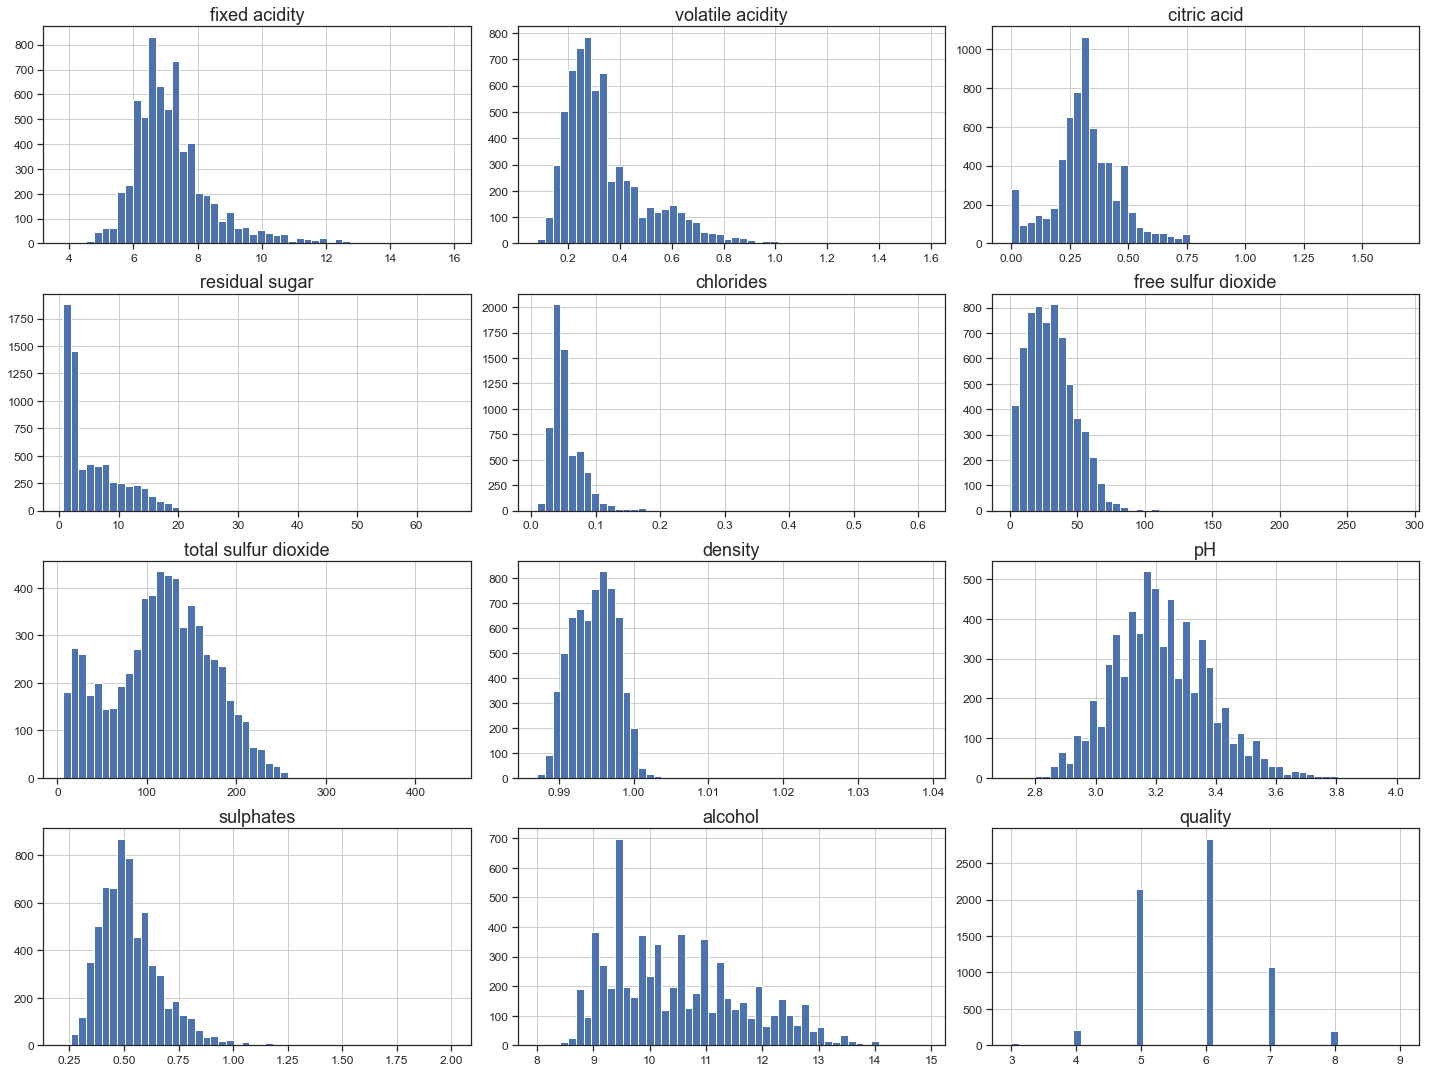

In [7]:
# 모든 숫자형 특성의 히스토그램
%matplotlib inline
import matplotlib.pyplot as plt
raw_df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# 2. EDA

### wines 로 copy

In [8]:
wines = raw_df.copy()
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### null값 확인 및 mean(평균)으로 대체

In [9]:
wines = wines.fillna(wines.mean())

In [10]:
wines.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
wines.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


### quality 를 low, medium, high 로 나눠서 quality_label 만들기

In [12]:
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 6 else 'high')


### feature별 상관관계 분석

In [13]:
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

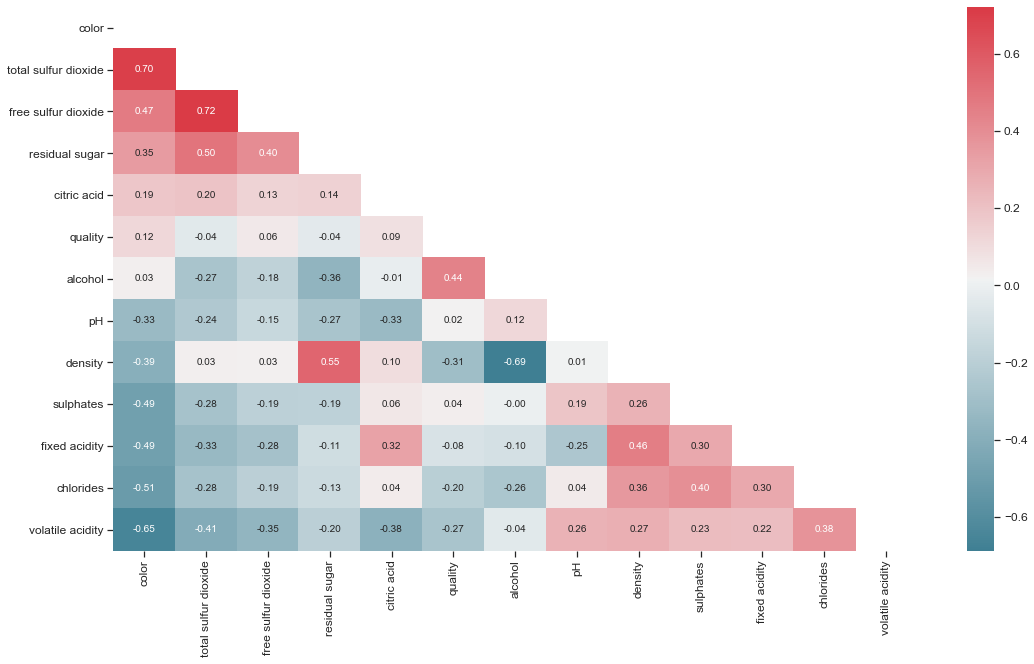

In [14]:
corr = wines.corr()
top_corr_cols = corr.color.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)
plt.show()
del corr, dropSelf, top_corr

### 1) 다운샘플링 이전 - 타입별(red, white) 데이터 분포도 확인

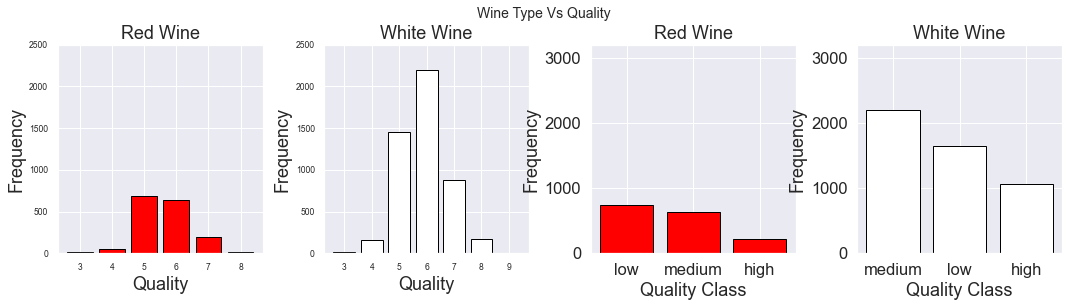

In [15]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wines.quality[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wines.quality[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = wines.quality_label[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = wines.quality_label[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

### 2) 다운샘플링 이전 - 타입별(red, white) 통계 분석

In [16]:
subset_attributes = wines.columns
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(), 2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(), 2)
pd.concat([rs, ws], axis = 0, keys = ['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   8.32   1.74  4.60   7.10   7.90   
volatile acidity                  1599.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1599.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1599.0  15.87  10.46  1.00   7.00  14.00   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   
color                             1599.0   0.00   0.00  0.00   0.00   0.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4898.0    6.86   0.84   
volatile acidity       0.64    1.58                4898.0    0.28   0.10   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         2.60   15.50                4898.0    6.39   5.07   
chlorides              0.09    0.61                4898.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4898.0   35.31  17.01   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.73    2.00                4898.0    0.49   0.11   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   
color                  0.00    0.00                4898.0    1.00   0.00   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00  
color                 1.00    1.00    1.00    1.00    1.00

### 3) 다운샘플링 이전 - 품질별(low, medium, high) 통계 분석

In [17]:
ls = round(wines[wines['quality_label'] == 'low'][wines.columns].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][wines.columns].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][wines.columns].describe(),2)
#pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

In [18]:
#LOW Quality wine
pd.concat([ls], axis=0, keys=['Low Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2384.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2384.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2384.0    5.65   4.92  0.60   1.80    2.90   
chlorides                      2384.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2384.0   29.48  19.84  2.00  14.00   26.00   
total sulfur dioxide           2384.0  119.28  61.89  6.00  68.00  124.00   
density                        2384.0    1.00   0.00  0.99   0.99    1.00   
pH                             2384.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2384.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2384.0    9.87   0.84  8.00   9.30    9.60   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   
color                          2384.0    0.69   0.46  0.00   0.00    1.00   

                                      
                         75%     max  
fixed acidity           7.80   15.90  
volatile acidity        0.50    1.58  
citric acid             0.40    1.00  
residual sugar          8.52   23.50  
chlorides               0.08    0.61  
free sulfur dioxide    42.00  289.00  
total sulfur dioxide  167.00  440.00  
density                 1.00    1.00  
pH                      3.31    3.90  
sulphates               0.58    2.00  
alcohol                10.40   14.90  
quality                 5.00    5.00  
color                   1.00    1.00

In [19]:
#Medium Quality wine
pd.concat([ms], axis=0, keys=['Medium Quality Wine']).T

Medium Quality Wine                                      \
                                   count    mean    std   min    25%     50%   
fixed acidity                     2836.0    7.18   1.29  3.80   6.40    6.90   
volatile acidity                  2836.0    0.31   0.15  0.08   0.21    0.27   
citric acid                       2836.0    0.32   0.14  0.00   0.26    0.31   
residual sugar                    2836.0    5.55   4.89  0.70   1.80    3.15   
chlorides                         2836.0    0.05   0.03  0.02   0.04    0.05   
free sulfur dioxide               2836.0   31.17  16.84  1.00  18.00   29.00   
total sulfur dioxide              2836.0  115.41  55.45  6.00  79.00  117.00   
density                           2836.0    0.99   0.00  0.99   0.99    0.99   
pH                                2836.0    3.22   0.16  2.72   3.11    3.21   
sulphates                         2836.0    0.53   0.15  0.23   0.43    0.51   
alcohol                           2836.0   10.59   1.13  8.40   9.60   10.50   
quality                           2836.0    6.00   0.00  6.00   6.00    6.00   
color                             2836.0    0.78   0.42  0.00   1.00    1.00   

                                      
                         75%     max  
fixed acidity           7.60   14.30  
volatile acidity        0.37    1.04  
citric acid             0.39    1.66  
residual sugar          8.30   65.80  
chlorides               0.06    0.42  
free sulfur dioxide    42.00  112.00  
total sulfur dioxide  156.00  294.00  
density                 1.00    1.04  
pH                      3.32    4.01  
sulphates               0.60    1.95  
alcohol                11.40   14.00  
quality                 6.00    6.00  
color                   1.00    1.00

In [20]:
#High Quality wine
pd.concat([hs], axis=0, keys=['High Quality Wine']).T

High Quality Wine                                      \
                                 count    mean    std   min    25%     50%   
fixed acidity                   1277.0    7.09   1.34  3.90   6.30    6.90   
volatile acidity                1277.0    0.29   0.12  0.08   0.20    0.27   
citric acid                     1277.0    0.33   0.11  0.00   0.28    0.32   
residual sugar                  1277.0    4.83   4.06  0.80   1.80    2.90   
chlorides                       1277.0    0.04   0.02  0.01   0.03    0.04   
free sulfur dioxide             1277.0   31.06  15.34  3.00  20.00   31.00   
total sulfur dioxide            1277.0  109.89  47.13  7.00  87.00  114.00   
density                         1277.0    0.99   0.00  0.99   0.99    0.99   
pH                              1277.0    3.23   0.16  2.84   3.12    3.22   
sulphates                       1277.0    0.54   0.16  0.22   0.42    0.51   
alcohol                         1277.0   11.43   1.22  8.50  10.70   11.50   
quality                         1277.0    7.16   0.38  7.00   7.00    7.00   
color                           1277.0    0.83   0.38  0.00   1.00    1.00   

                                      
                         75%     max  
fixed acidity           7.40   15.60  
volatile acidity        0.34    0.92  
citric acid             0.38    0.76  
residual sugar          6.50   19.25  
chlorides               0.05    0.36  
free sulfur dioxide    40.00  108.00  
total sulfur dioxide  140.00  289.00  
density                 1.00    1.00  
pH                      3.34    3.82  
sulphates               0.64    1.36  
alcohol                12.40   14.20  
quality                 7.00    9.00  
color                   1.00    1.00


### 0-0) 불필요한 column 삭제

In [21]:
# type -> color / quality -> quality_label로 변경했으므로 삭제

# quality 지우는 거에서 quality_label 을 지우는 것으로 변경(박정현)
wines_copy = wines.copy() # 추후에 품질 예측에서 X, Y 나누기 위해 활용
wines_downsampled = wines.copy() # downsample 분포도 그리기 위해 활용

wines = wines.drop(['type', 'quality_label'], axis=1)
wines_copy = wines_copy.drop(['type', 'quality'], axis=1)

### 0-1) red vs white 분류문제: 다운 샘플링 진행
- X_type: type 데이터의 X 
- Y_type: type 데이터의 label

- X_train_type, X_test_type: type X 데이터의 train, test 데이터
- Y_train_type, Y_test_type: type label 데이터의 train, test 데이터

In [22]:
X = wines.drop('color', axis=1)
y = wines['color']

y = np.where((y == 0), 0, 1)

In [23]:
# not null로 데이터 존재 유무 확인해야 될듯?
i_class0 = np.where(y == 0)[0]
i_class1 = np.where(y == 1)[0]

# 각 클래스의 데이터 개수 확인
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# 화이트와인 클래스의 개수를 레드와인 클래스의 개수와 매칭
i_class1_downsampled = np.random.choice(i_class1, size=n_class0, replace=False)

# 화이트와인 클래스와 레드와인 클래스 병합
Y_type = np.hstack((y[i_class0], y[i_class1_downsampled]))  # 화이트 + 레드 y

In [24]:
X.loc[list(i_class0),:]  # 레드와인 X
X.loc[list(i_class1_downsampled),:]  # 화이트와인 X
a = X.loc[list(i_class0),:]
b = X.loc[list(i_class1_downsampled),:]
X_type = a.append(b, sort=False) # 화이트 + 레드 X

# downsample 분포도 그리기 위해 wines_downsampled 정의
wines_downsampled.loc[list(i_class0),:]  # 레드와인 X
wines_downsampled.loc[list(i_class1_downsampled),:]  # 화이트와인 X
a = wines_downsampled.loc[list(i_class0),:]
b = wines_downsampled.loc[list(i_class1_downsampled),:]
wines_downsampled = a.append(b, sort=False) # 화이트 + 레드 X

In [25]:
# split
X_train_type, X_test_type, Y_train_type, Y_test_type = train_test_split(X_type, Y_type, test_size=0.2, random_state=321)


In [26]:
print("X_train_type.shape: ", X_train_type.shape)
print("Y_train_type.shape: ", Y_train_type.shape)
print("X_test_type.shape: ", X_test_type.shape)
print("Y_test_type.shape: ", Y_test_type.shape)

X_train_type.shape:  (2558, 12)
Y_train_type.shape:  (2558,)
X_test_type.shape:  (640, 12)
Y_test_type.shape:  (640,)


### 0-2) low, medium, high 예측문제
- X_quality: quality 데이터의 X
- Y_quality: quality 데이터의 label

- X_train_quality, X_test_quality: quality X 데이터의 train, test 데이터
- Y_train_quality, Y_test_quality: quality label 데이터의 train, test 데이터

In [27]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.3,0.28,0.42,14.4,0.040,49.0,173.0,0.99940,3.28,0.82,9.0,7,1
1,6.9,1.09,0.06,2.1,0.061,12.0,31.0,0.99480,3.51,0.43,11.4,4,0
2,9.5,0.46,0.24,2.7,0.092,14.0,44.0,0.99800,3.12,0.74,10.0,6,0
3,8.2,0.31,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.2,7,0
4,7.9,0.28,0.41,4.9,0.058,31.0,153.0,0.99660,3.27,0.51,9.7,6,1


In [28]:
X_quality = wines_copy.drop('quality_label', axis=1)
Y_quality = wines_copy['quality_label']

In [29]:
# split
X_train_quality, X_test_quality, Y_train_quality, Y_test_quality = train_test_split(X_quality, Y_quality, test_size=0.2, random_state=321)


In [30]:
print("X_train_quality.shape: ", X_train_quality.shape)
print("Y_train_quality.shape: ", Y_train_quality.shape)
print("X_test_quality.shape: ", X_test_quality.shape)
print("Y_test_quality.shape: ", Y_test_quality.shape)

X_train_quality.shape:  (5197, 12)
Y_train_quality.shape:  (5197,)
X_test_quality.shape:  (1300, 12)
Y_test_quality.shape:  (1300,)


In [31]:
X_train_quality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
2281,5.0,0.33,0.23,11.8,0.030,23.0,158.0,0.99322,3.41,0.64,11.8,1
3652,8.9,0.84,0.34,1.4,0.050,4.0,10.0,0.99554,3.12,0.48,9.1,0
3364,7.8,0.27,0.28,1.8,0.050,21.0,127.0,0.99340,3.15,0.44,9.9,1
5127,9.4,0.30,0.56,2.8,0.080,6.0,17.0,0.99640,3.15,0.92,11.7,0
3492,7.2,0.32,0.40,8.7,0.038,45.0,154.0,0.99568,3.20,0.47,10.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1425,6.2,0.35,0.04,1.2,0.060,23.0,108.0,0.99340,3.26,0.54,9.2,1
3784,8.8,0.41,0.64,2.2,0.093,9.0,42.0,0.99860,3.54,0.66,10.5,0
5929,6.6,0.23,0.37,8.5,0.036,46.0,153.0,0.99576,3.20,0.48,9.4,1
2847,6.5,0.53,0.06,2.0,0.063,29.0,44.0,0.99489,3.38,0.83,10.3,0


### 1) 다운샘플링 이후 - 타입별(red, white) 데이터 분포도 확인

In [32]:
# color == 0 : white / color == 1 : red

In [33]:
wines_downsampled

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,color
1,red,6.9,1.09,0.06,2.1,0.061,12.0,31.0,0.994800,3.51,0.43,11.4,4,low,0
2,red,9.5,0.46,0.24,2.7,0.092,14.0,44.0,0.998000,3.12,0.74,10.0,6,medium,0
3,red,8.2,0.31,0.40,2.2,0.058,6.0,10.0,0.995360,3.31,0.68,11.2,7,high,0
5,red,9.8,0.34,0.39,1.4,0.066,3.0,7.0,0.994700,3.19,0.55,11.4,7,high,0
8,red,7.3,0.38,0.21,2.0,0.080,7.0,35.0,0.996100,3.33,0.47,9.5,5,low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,white,6.3,0.25,0.53,1.8,0.021,41.0,101.0,0.989315,3.19,0.31,13.0,6,medium,1
3089,white,7.0,0.16,0.30,2.6,0.043,34.0,90.0,0.990470,2.88,0.47,11.2,6,medium,1
5513,white,6.9,0.19,0.35,13.5,0.038,49.0,118.0,0.995460,3.00,0.63,10.7,6,medium,1
1377,white,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.994800,3.19,0.69,9.4,6,medium,1


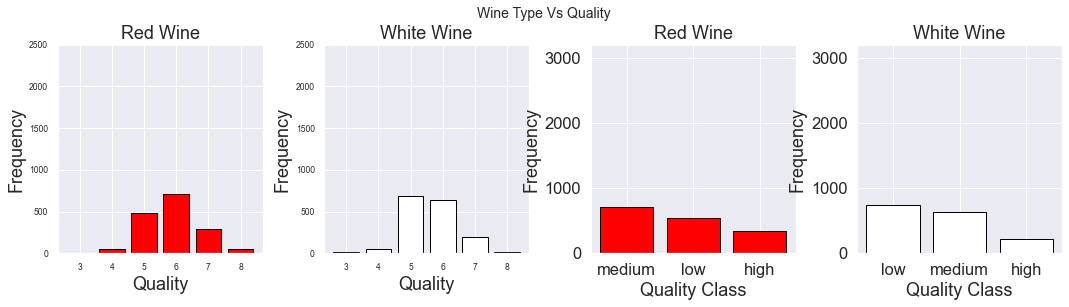

In [34]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wines_downsampled.quality[wines_downsampled.color == 1].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wines_downsampled.quality[wines_downsampled.color == 0].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = wines_downsampled.quality_label[wines_downsampled.color == 1].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = wines_downsampled.quality_label[wines_downsampled.color == 0].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

### 2) 다운샘플링 이후 - 타입별(red, white) 통계 분석

In [35]:
subset_attributes = wines_downsampled.columns
rs = round(wines_downsampled.loc[wines_downsampled.color == 1, subset_attributes].describe(), 2)
ws = round(wines_downsampled.loc[wines_downsampled.color == 0, subset_attributes].describe(), 2)
pd.concat([rs, ws], axis = 0, keys = ['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                       \
                                   count    mean    std   min     25%     50%   
fixed acidity                     1599.0    6.82   0.81  4.20    6.30    6.80   
volatile acidity                  1599.0    0.28   0.10  0.08    0.21    0.26   
citric acid                       1599.0    0.33   0.13  0.00    0.26    0.31   
residual sugar                    1599.0    6.43   5.23  0.60    1.72    5.20   
chlorides                         1599.0    0.05   0.02  0.01    0.04    0.04   
free sulfur dioxide               1599.0   35.64  18.34  3.00   23.00   34.00   
total sulfur dioxide              1599.0  138.90  43.22  9.00  109.00  135.00   
density                           1599.0    0.99   0.00  0.99    0.99    0.99   
pH                                1599.0    3.19   0.15  2.77    3.09    3.18   
sulphates                         1599.0    0.49   0.11  0.22    0.41    0.48   
alcohol                           1599.0   10.50   1.23  8.00    9.50   10.30   
quality                           1599.0    5.87   0.88  3.00    5.00    6.00   
color                             1599.0    1.00   0.00  1.00    1.00    1.00   

                                     White Wine Statistics                \
                         75%     max                 count   mean    std   
fixed acidity           7.30   10.70                1599.0   8.32   1.74   
volatile acidity        0.33    0.96                1599.0   0.53   0.18   
citric acid             0.38    1.66                1599.0   0.27   0.19   
residual sugar          9.90   65.80                1599.0   2.54   1.41   
chlorides               0.05    0.35                1599.0   0.09   0.05   
free sulfur dioxide    46.00  289.00                1599.0  15.87  10.46   
total sulfur dioxide  166.00  440.00                1599.0  46.47  32.90   
density                 1.00    1.04                1599.0   1.00   0.00   
pH                      3.29    3.82                1599.0   3.31   0.15   
sulphates               0.54    0.98                1599.0   0.66   0.17   
alcohol                11.40   14.20                1599.0  10.42   1.07   
quality                 6.00    8.00                1599.0   5.64   0.81   
color                   1.00    1.00                1599.0   0.00   0.00   

                                                         
                       min    25%    50%    75%     max  
fixed acidity         4.60   7.10   7.90   9.20   15.90  
volatile acidity      0.12   0.39   0.52   0.64    1.58  
citric acid           0.00   0.09   0.26   0.42    1.00  
residual sugar        0.90   1.90   2.20   2.60   15.50  
chlorides             0.01   0.07   0.08   0.09    0.61  
free sulfur dioxide   1.00   7.00  14.00  21.00   72.00  
total sulfur dioxide  6.00  22.00  38.00  62.00  289.00  
density               0.99   1.00   1.00   1.00    1.00  
pH                    2.74   3.21   3.31   3.40    4.01  
sulphates             0.33   0.55   0.62   0.73    2.00  
alcohol               8.40   9.50  10.20  11.10   14.90  
quality               3.00   5.00   6.00   6.00    8.00  
color                 0.00   0.00   0.00   0.00    0.00

### 3) 다운샘플링 이후 - 품질별(low, medium, high) 통계 분석

In [36]:
ls = round(wines_downsampled[wines_downsampled['quality_label'] == 'low'][wines_downsampled.columns].describe(),2)
ms = round(wines_downsampled[wines_downsampled['quality_label'] == 'medium'][wines_downsampled.columns].describe(),2)
hs = round(wines_downsampled[wines_downsampled['quality_label'] == 'high'][wines_downsampled.columns].describe(),2)
#pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

In [37]:
pd.concat([ls], axis=0, keys=['Low Quality Wine']).T

Low Quality Wine                                    \
                                count   mean    std   min    25%    50%   
fixed acidity                  1290.0   7.62   1.45  4.50   6.70   7.30   
volatile acidity               1290.0   0.47   0.21  0.10   0.31   0.43   
citric acid                    1290.0   0.28   0.17  0.00   0.15   0.26   
residual sugar                 1290.0   4.43   4.24  0.60   1.80   2.30   
chlorides                      1290.0   0.08   0.05  0.01   0.05   0.07   
free sulfur dioxide            1290.0  24.73  19.64  3.00  11.00  20.00   
total sulfur dioxide           1290.0  94.71  63.15  6.00  38.00  86.00   
density                        1290.0   1.00   0.00  0.99   0.99   1.00   
pH                             1290.0   3.25   0.16  2.74   3.14   3.25   
sulphates                      1290.0   0.56   0.16  0.28   0.47   0.54   
alcohol                        1290.0   9.88   0.81  8.00   9.40   9.60   
quality                        1290.0   4.89   0.34  3.00   5.00   5.00   
color                          1290.0   0.42   0.49  0.00   0.00   0.00   

                                      
                         75%     max  
fixed acidity           8.20   15.90  
volatile acidity        0.61    1.58  
citric acid             0.39    1.00  
residual sugar          5.68   22.60  
chlorides               0.09    0.61  
free sulfur dioxide    34.00  289.00  
total sulfur dioxide  143.00  440.00  
density                 1.00    1.00  
pH                      3.36    3.90  
sulphates               0.62    2.00  
alcohol                10.30   14.90  
quality                 5.00    5.00  
color                   1.00    1.00

In [38]:
pd.concat([ms], axis=0, keys=['Medium Quality Wine']).T

Medium Quality Wine                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1346.0   7.54   1.56  4.70   6.50   7.10   
volatile acidity                  1346.0   0.37   0.17  0.08   0.24   0.33   
citric acid                       1346.0   0.31   0.17  0.00   0.23   0.30   
residual sugar                    1346.0   4.60   4.56  0.70   1.90   2.40   
chlorides                         1346.0   0.06   0.04  0.02   0.04   0.06   
free sulfur dioxide               1346.0  26.44  16.81  1.00  14.00  24.00   
total sulfur dioxide              1346.0  91.69  59.31  6.00  37.00  87.00   
density                           1346.0   1.00   0.00  0.99   0.99   1.00   
pH                                1346.0   3.25   0.16  2.77   3.14   3.25   
sulphates                         1346.0   0.58   0.17  0.23   0.46   0.56   
alcohol                           1346.0  10.61   1.11  8.40   9.70  10.50   
quality                           1346.0   6.00   0.00  6.00   6.00   6.00   
color                             1346.0   0.53   0.50  0.00   0.00   1.00   

                                      
                         75%     max  
fixed acidity           8.07   14.30  
volatile acidity        0.49    1.04  
citric acid             0.40    1.66  
residual sugar          6.30   65.80  
chlorides               0.08    0.42  
free sulfur dioxide    36.00  108.00  
total sulfur dioxide  137.00  294.00  
density                 1.00    1.04  
pH                      3.36    4.01  
sulphates               0.66    1.95  
alcohol                11.40   14.00  
quality                 6.00    6.00  
color                   1.00    1.00

In [39]:
pd.concat([hs], axis=0, keys=['High Quality Wine']).T

High Quality Wine                                    \
                                 count   mean    std   min    25%    50%   
fixed acidity                    562.0   7.54   1.73  4.20   6.50   7.10   
volatile acidity                 562.0   0.32   0.14  0.08   0.22   0.30   
citric acid                      562.0   0.34   0.14  0.00   0.28   0.33   
residual sugar                   562.0   4.35   3.72  0.90   1.81   2.55   
chlorides                        562.0   0.05   0.03  0.01   0.04   0.04   
free sulfur dioxide              562.0  26.50  16.11  3.00  13.00  25.00   
total sulfur dioxide             562.0  90.43  54.45  7.00  35.00  99.50   
density                          562.0   0.99   0.00  0.99   0.99   0.99   
pH                               562.0   3.24   0.16  2.88   3.14   3.23   
sulphates                        562.0   0.59   0.18  0.22   0.44   0.57   
alcohol                          562.0  11.45   1.14  8.60  10.80  11.50   
quality                          562.0   7.13   0.33  7.00   7.00   7.00   
color                            562.0   0.61   0.49  0.00   0.00   1.00   

                                      
                         75%     max  
fixed acidity           8.20   15.60  
volatile acidity        0.39    0.92  
citric acid             0.41    0.76  
residual sugar          5.84   19.25  
chlorides               0.07    0.36  
free sulfur dioxide    37.88  105.00  
total sulfur dioxide  130.00  289.00  
density                 1.00    1.00  
pH                      3.35    3.82  
sulphates               0.72    1.36  
alcohol                12.30   14.20  
quality                 7.00    8.00  
color                   1.00    1.00

In [40]:
# 분포도 해석



### DNN

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Mean Best Accuracy : 98.79%
20/20 [==============================] - 0s 1ms/step - loss: 0.0769 - accuracy: 0.9922
accuracy:  99.22%


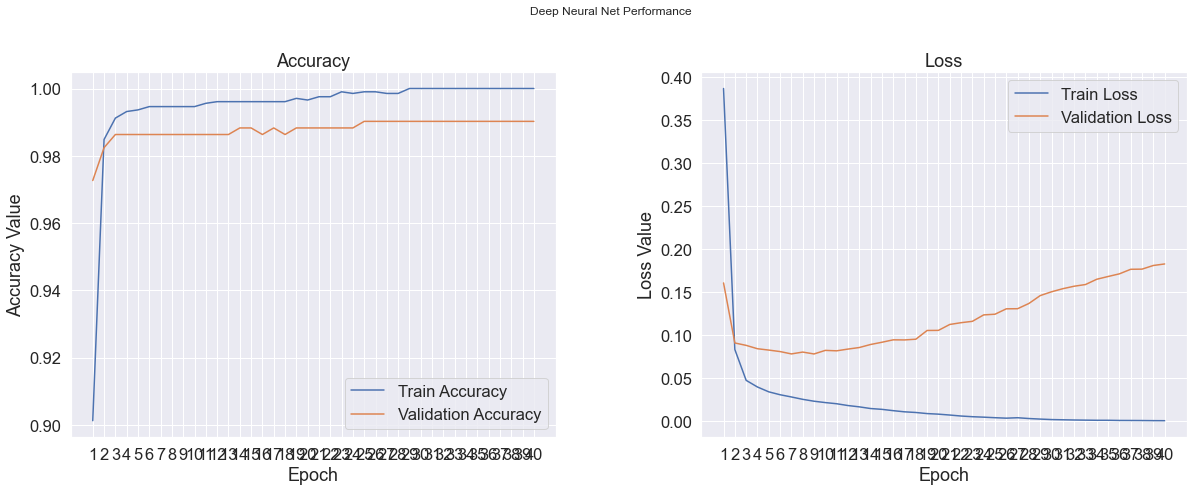

In [41]:
#Define the scaler
wtp_ss = StandardScaler().fit(X_train_type)

#Scale the train set
X_train_Ss = wtp_ss.transform(X_train_type)

#Scale the test set
X_test_Ss = wtp_ss.transform(X_test_type)

#모델 구성하기
wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(64, activation = 'relu', input_shape = (12,)))
wtp_dnn_model.add(Dense(32, activation='relu'))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(1, activation='sigmoid'))

#모델 학습과정 설정하기
wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#모델 학습시키기
epochs=40
history = wtp_dnn_model.fit(X_train_Ss, Y_train_type, epochs=epochs, batch_size=50, 
                            shuffle=True, validation_split=0.2, verbose=0)

wtp_dnn_ypred = wtp_dnn_model.predict_classes(X_test_Ss)
wtp_dnn_predictions = class_tp.inverse_transform(wtp_dnn_ypred) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,epochs+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

#모델 평가하기
print("================================")
best = np.mean(history.history['val_accuracy'])
print("Mean Best Accuracy : {:2.2%}".format(best))

print("================================")
scores = wtp_dnn_model.evaluate(X_test_Ss, Y_test_type)
print("%s:  %.2f%%" %(wtp_dnn_model.metrics_names[1], scores[1]*100))

In [42]:
wtp_dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


### DNN 설명

- Sequential 
    - 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합
    - add() 메서드를 통해 Sequential 모델을 점진적으로 작성할 수 있다. 

- Dense
    - 입력과 출력을 모두 연결해준다.
    - 예시) Dense(8, input_dim = 4, init = 'uniform', activation = 'relu'

- 첫 번째 인자 8 : 출력 뉴런의 수
- input_dim : 입력 뉴런의 수 
- init : 가중치 초기화 방법 
    - 'uniform' : 균일 분포
    - 'normal' : 가우시안 분포 
- activation : 활성화 함수 설정 
    - 'linear' : 디폴트 값, 입력 뉴런과 가중치로 계산된 결과값이 그대로 출력된다.
    - 'relu' : rectifier 함수, 은닉층에 주로 쓰인다.
    - 'sigmoid' : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰인다.
    - 'softmax' : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰인다.
    
- 모델 학습과정 설정하기 
    - loss : 현재 가중치 세트를 평가하는데 사용한 손실 함수. 이진 클래스 문제이면 'binary_crossentropy'으로 지정한다.
    - optimizer : 최적의 가중치를 검색하는데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 'adam'을 사용한다. 
    - metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 'accuracy' 으로 지정한다. 
    
- 모델 학습시키기
    - 모델을 학습시키기 위해서는 fit() 함수를 사용한다. 
    - fit 함수에서 첫번째 인자는 입력 변수를 의미한다. 8개의 속성 값을 담고 있는 X를 입력한다.
    - 두번째 인자는 출력 변수 즉 라벨값이다. 결과 값을 담고 있는 Y를 입력한다. 
    - epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정한다. 
    - batch_size : 가중치를 업데이트할 배치 크기를 의미한다. 
    


In [43]:
# results = get_results(wtp_dnn_model, 'DNN Regressor', X_test_Ss, y_test,
#                       target_names = ['red', 'white'], results = results, reasume=False)

In [45]:
# gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
# LR = Pipeline([
#         #('sel', select_fetaures(select_cols=list(shadow))),
#         ('scl', StandardScaler()),
#         #('lda', LDA(store_covariance=True)),
#         ('gs', gs)
#  ]) 

# LR.fit(X_train_type, Y_train_type)

In [46]:
# y_pred_keras = wtp_dnn_model.predict(X_test_Ss).ravel()
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test_type, y_pred_keras)
# auc_keras = auc(fpr_keras, tpr_keras)

# y_pred_clf = LR.predict_proba(X_test_type)[:, 1]
# fpr_clf, tpr_clf, thresholds_clf = roc_curve(Y_test_type, y_pred_clf)
# auc_clf = auc(fpr_clf, tpr_clf)

# fig = plt.figure(figsize=(20, 7))
# ax = fig.add_subplot(121)
# ax.plot([0, 1], [0, 1], 'k--')
# ax.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# ax.plot(fpr_clf, tpr_clf, label='LR (area = {:.3f})'.format(auc_clf))
# ax.set_xlabel('False positive rate')
# ax.set_ylabel('True positive rate')
# ax.set_title('ROC curve')
# ax.legend(loc='best')

# # Zoom in view of the upper left corner.
# ax2 = fig.add_subplot(122)
# ax2.set_xlim(-0.01, 0.2)
# ax2.set_ylim(0.7, 1.01)
# ax2.plot([0, 1], [0, 1], 'k--')
# ax2.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# ax2.plot(fpr_clf, tpr_clf, label='LR (area = {:.3f})'.format(auc_clf))
# ax2.set_xlabel('False positive rate')
# ax2.set_ylabel('True positive rate')
# ax2.set_title('ROC curve (zoomed in at top left)')
# ax2.legend(loc='best')
# plt.show()

# display(results.sort_values(by='Accuracy', ascending=False))

## Random Forest Classifier

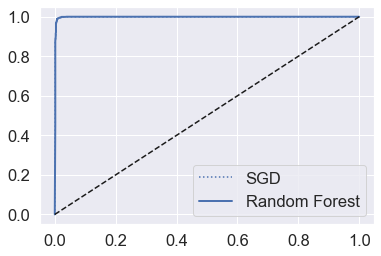

In [47]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_type, Y_train_type)

y_trained_pred = cross_val_predict(sgd_clf, X_train_type, Y_train_type, cv=3)

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train_type, Y_train_type, cv=3, method="predict_proba")


y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_train_type, y_scores_forest)



def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    

plt.plot(fpr_forest, tpr_forest, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [49]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_type, Y_train_type)

y_trained_pred = cross_val_predict(sgd_clf, X_train_type, Y_train_type, cv=3)

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train_type, Y_train_type, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_train_type, y_scores_forest)

In [ ]:
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

In [ ]:
plt.plot(fpr_forest, tpr_forest, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


# plt.plot(fpr_forest, tpr_forest, "b:", label="SGD")
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.plot(X_train_type, label='X train')
# plt.plot(Y_train_type, label='Y train', linestyle='--')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
plt.plot(fpr_dnn, tpr_dnn, "b:", label="SGD")
plot_roc_curve(fpr_dnn, tpr_dnn, "DNN")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
        ('clf', RandomForestClassifier(random_state=101))])  

cols = wines.columns
SEL = cols
n_components= [len(SEL)-2, len(SEL)-1, len(SEL)] 
whiten = [True, False]
criterion = ['gini', 'entropy']
class_weight = ['balanced', None] 
n_estimators = [155, 175]  
max_depth  = [20, None]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1]

param_grid = \
    [{ 
      'clf__criterion': criterion
      ,'clf__n_estimators': n_estimators      
      ,'clf__min_samples_split': min_samples_split
      ,'clf__max_depth': max_depth
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
RF = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

RF.fit(X_train_type, Y_train_type)

# results = get_results(RF, 'RF', X_test_type, Y_test_type, 
#                       target_names = target_names, results = results, reasume=False)

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')

fpr_forest, tpr_forest, thresholds_forest = plot_roc_curve(X_train_type, Y_train_type )

plt.plot(fpr_forest, tpr_forest, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### DNN roc curve

### 방법1)

In [51]:
sgd_clf_dnn = SGDClassifier(random_state=42)
sgd_clf_dnn.fit(X_train_type, Y_train_type)

y_trained_pred_dnn = cross_val_predict(sgd_clf_dnn, X_train_type, Y_train_type, cv=3)

dnn_clf = Sequential()
y_probas_dnn = cross_val_predict(dnn_clf, X_train_type, Y_train_type, cv=3, method="predict_proba")

TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8ce8719760>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
y_scores_dnn = y_probas_dnn[:, 1]
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(Y_train_type, y_scores_dnn)

### 방법2)

In [53]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
for i in range(n_classes):
    fpr_dnn[i], tpr_dnn[i], _ = roc_curve_dnn(Y_test_type[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### 방법3)

In [57]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0)
mlpc.fit(X_train_type, Y_train_type)
y_pred = mlpc.predict(X_test_type)

In [58]:
mlpc_params = {"alpha": [0.1, 0.01, 0.0001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}

from sklearn.model_selection import GridSearchCV

In [59]:
# Model CV process 
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 5, # To make a 5-fold CV
                         n_jobs = -1, # Number of jobs to be run in parallel (-1: means to use all processors)
                         verbose = 2) # Controls the level of detail: higher means more messages gets value as integer.

mlpc_cv_model.fit(X_train_type, Y_train_type)

# The best parameter obtained as a result of CV process

print("The best parameters: " + str(mlpc_cv_model.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.2min finished


The best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}


In [60]:
# Model Tuning
# Setting the Final Model with the best parameter

mlpc_tuned = mlpc_cv_model.best_estimator_

# Fitting Final Model
mlpc_tuned.fit(X_train_type, Y_train_type)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100, 100),
              random_state=0)

In [64]:
# K-fold f1_weighted

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# K fold
kf = KFold(shuffle=True, n_splits=5) # To make a 5-fold CV

cv_results_kfold = cross_val_score(mlpc_tuned, X_test_type, np.argmax(Y_test_type, axis=1), cv=kf, scoring= 'f1_weighted')

print("K-fold Cross Validation f1_weigted Results: ",cv_results_kfold)
print("K-fold Cross Validation f1_weigted Results Mean: ",cv_results_kfold.mean())

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# K-fold accuracy

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# K fold
kf = KFold(shuffle=True, n_splits=5) # To make a 5-fold CV

cv_results_kfold = cross_val_score(mlpc_tuned, X_test_type, np.argmax(Y_test_type, axis=1), cv=kf, scoring= 'accuracy')

print("K-fold Cross Validation accuracy Results: ",cv_results_kfold)
print("K-fold Cross Validation accuracy Results Mean: ",cv_results_kfold.mean())

In [ ]:
# Tune Model Prediction
# Prediction process of Final Model over test set
y_pred = mlpc_tuned.predict(X_test_type)

In [ ]:
# Accuracy and f1_weighted value of Final Model

# %% f1 score
import sklearn.metrics as metrics
print("f1_weighted:",metrics.f1_score(np.argmax(Y_test_type, axis=1), np.argmax(y_pred, axis=1),average='weighted'))

# %% Accuracy

print("accuracy:",metrics.accuracy_score(np.argmax(Y_test_type, axis=1), np.argmax(y_pred, axis=1)))

In [62]:
#%% Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report 

# Classification Report
model_report = classification_report(np.argmax(Y_test_type, axis=1), np.argmax(y_pred, axis=1))
print(model_report)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Confusion Matrix
# multilabel-indicator is not supported so np.argmax should be used!
model_conf = confusion_matrix(np.argmax(Y_test_type, axis=1), np.argmax(y_pred, axis=1))
print(model_conf)

In [ ]:
#%% ROC-AUC Curve

y_score = mlpc_tuned.predict_proba(X_test_type)

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 3 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_type[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_type.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# The process of drawing a roc-auc curve belonging to a specific class

plt.figure()
lw = 2 # line_width
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()